In [1]:
import numpy as np
import scipy.signal as signal
from scipy.fftpack import fft
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from joblib import Parallel, delayed

from statsmodels.tsa.ar_model import AR

from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
!ls

alexander_bci.csv	  ekaterina_bci.csv	    renata_experiment.csv
alexander_experiment.csv  ekaterina_experiment.csv  viktoria_bci.csv
analysis.ipynb		  michael_bci.csv	    viktoria_experiment.csv
egor_bci.csv		  michael_experiment.csv
egor_experiment.csv	  renata_bci.csv


In [3]:
sfreq = 250
nyq = sfreq / 2
epoch_len = 250
epoch_step = 50

cut_begin = 150
cut_end = 150

names = ['alexander', 'egor', 'ekaterina', 'michael', 'renata', 'viktoria']
n_subjects = len(names)
n_classes = 11
n_experiments = 8

In [4]:
data = [np.genfromtxt(name+'_bci.csv', delimiter=';') for name in names]
data_y = [np.genfromtxt(name+'_experiment.csv', delimiter=';') for name in names]

In [5]:
signal_timestamps, signals_raw = zip(*[(timeseries[:, 0], timeseries[:, 1:]) for timeseries in data])
class_timestamps, class_raw = zip(*[(timeseries[:, 0], timeseries[:, 1:]) for timeseries in data_y])

signals_raw = list(signals_raw)

In [6]:
print([len(timestamp) for timestamp in signal_timestamps])
print([len(timestamp) for timestamp in class_timestamps])

[238966, 238979, 239079, 239071, 238725, 239042]
[161, 161, 161, 161, 161, 161]


In [7]:
print([250*np.std(timestamp[1:]-timestamp[:-1]) for timestamp in signal_timestamps])

[0.13786640348495352, 0.15282591925661212, 0.14585839087166655, 0.13869983557062657, 0.36669608824695055, 0.13844364268230558]


In [8]:


for i in range(len(signals_raw)):
    signals_raw[i] = signals_raw[i] - signals_raw[i].mean(axis=1, keepdims=True)
    signals_raw[i] = signals_raw[i] - np.mean(signals_raw[i], axis=0, keepdims=True)

In [9]:
#Filtering

In [10]:
die_window = 3
live_window = 4
live_gain = 2 ** 0.5

freq = [0, 3, 5,
        50-live_window, 50-die_window, 50+die_window, 50+live_window,
        100-live_window, 100-die_window, 100+die_window, 100+live_window,
        nyq]

gain = [0, 0, 2 ** 0.5,
        live_gain, 0, 0, live_gain,
        live_gain, 0, 0, live_gain,
        1]

b = signal.firwin2(sfreq, freq, gain, nyq=nyq, antisymmetric=True)

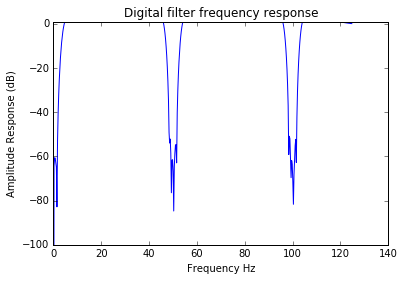

In [11]:
w, h = signal.freqz(b)
plt.title('Digital filter frequency response')
plt.plot(w/np.pi*nyq, 20*np.log10(np.abs(h)), 'b')
#plt.plot(w2, 20*np.log10(np.abs(h2)), 'r')
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency Hz')
plt.ylim((-100, 1))
#plt.grid()
plt.show()

In [12]:
signals_filtered = list(signals_raw)

for i in range(len(signals_raw)):
    signals_filtered[i] = signal.lfilter(b, 1, signals_raw[i], axis=0)

In [13]:
signals_filtered[0].shape

(238966, 8)

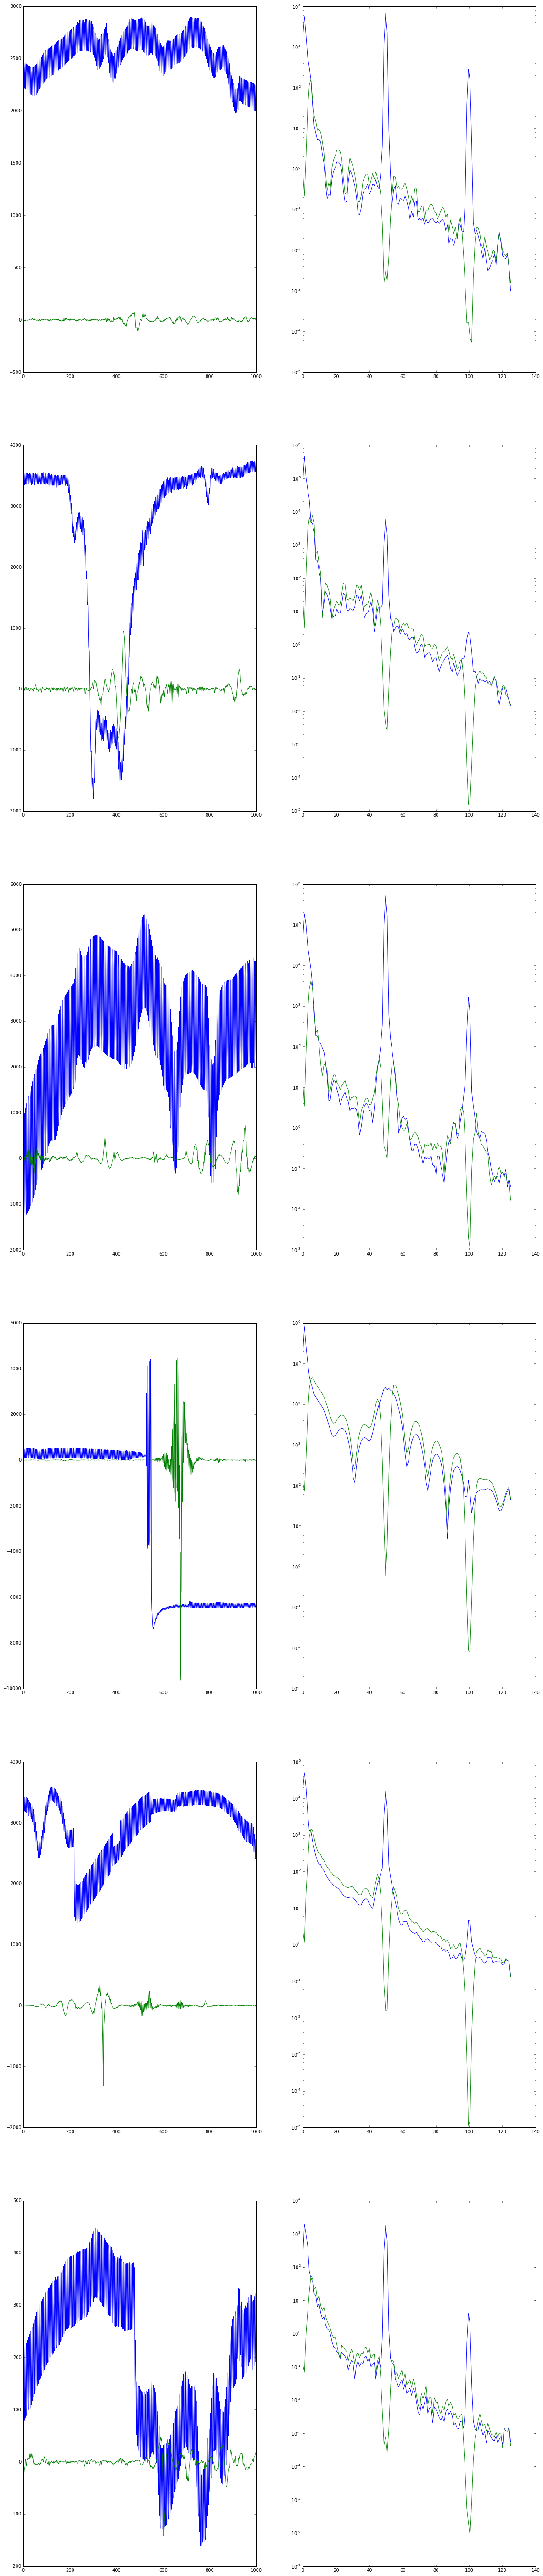

In [14]:
fig, axes = plt.subplots(nrows=n_subjects, ncols=2, figsize=(20, 100))

for i, a in enumerate(axes):
    x_t = signals_raw[i][1000:2000][:, 0]
    a[0].plot(x_t)

    f, p = signal.welch(x_t.T, fs=sfreq)
    a[1].semilogy(f, p.T)
    
    x_t = signals_filtered[i][1000:2000][:, 0]
    a[0].plot(x_t)
    
    f, p = signal.welch(x_t.T, fs=sfreq)
    a[1].semilogy(f, p.T)
plt.show()

In [15]:
signals_raw = signals_filtered

In [16]:
signals_raw[0].shape

(238966, 8)

In [17]:
def get_epochs(signals_raw, signal_timestamps, class_raw, class_timestamps):
    new_signals_raw, new_class_raw = [], []
    for x, x_timestamp, y, y_timestamp in zip(signals_raw, signal_timestamps, class_raw, class_timestamps):
        new_x, new_y = [], []
        for i in range(len(y)-1):
            mask = (x_timestamp > y_timestamp[i]) & (x_timestamp < y_timestamp[i+1])
            temp_x = x[mask]
            # Cut beginning and an end
            new_x_vals = []
            new_y_vals = []
            for j in range(cut_begin, len(temp_x)-cut_end-epoch_len, epoch_step):
                new_x_vals.append(temp_x[j:epoch_len+j])
                new_y_vals.append(int(y[i]))

            new_x.extend(new_x_vals)
            new_y.extend(new_y_vals)
            #print(new_x_vals[0.shape)

        new_signals_raw.append(np.array(new_x))
        new_class_raw.append(np.array(new_y))
    return new_signals_raw, new_class_raw

In [18]:
xs, ys = get_epochs(signals_raw, signal_timestamps, class_raw, class_timestamps)

In [19]:
def ft_augment(c):
    if not hasattr(c, 'fit_transform'):
        class augmented_class(c):
            def fit_transform(self, x, y):
                self.fit(x, y)
                return self.transform(x)
        return augmented_class
    else:
        return c

@ft_augment
class TransformerWrapper:
    def __init__(self, *transformers):
        assert len(transformers) > 0
        self.transformers = transformers
    
    def fit(self, x, y=None):
        pass
    
    def transform(self, x):
        x_t = transformers[0](x)
        for t in transformers[1:]:
            x_t = np.hstack((x_t, t(x)))
        return x_t
        
def diff_abs(x):
    past_val = x[..., :-1] 
    cur_val = x[..., 1:]
    diff = cur_val - past_val
    return np.abs(x).sum(axis=-1)

def h_activity(x):
    #print(x.var(axis=-1).shape)
    return x.var(axis=-1)

def h_mobility(x):
    x_prev = x[..., :-2]
    x_cur = x[..., 1:-1]
    x_next = x[..., 2:]
    
    x_diff = x_next - x_prev
    return (h_activity(x_cur * x_diff) / h_activity(x)) ** 0.5

def h_complexity(x):
    x_prev = x[..., :-2]
    x_cur = x[..., 1:-1]
    x_next = x[..., 2:]
    
    x_diff = x_next - x_prev
    return h_mobility(x_cur * x_diff) / h_mobility(x)

def zc(x):
    x_prev = x[..., :-1] 
    x_next = x[..., 1:]
    zero_crossing = (x_prev * x_next) > 0
    return zero_crossing.sum(axis=-1)

def slope_sign_change(x):
    x_prev = x[..., :-1]
    x_next = x[..., 1:]
    x_diff = x_next - x_prev
    return zc(x_diff)

def skewness(x):
    return (((x - x.mean(axis=-1, keepdims=True)) / x.var(axis=-1, keepdims=True) ** 0.5) ** 3).mean(axis=-1)

def ar_features(x, maxlag=6):
    return np.hstack([AR(c).fit(maxlag=maxlag).params for c in x])

def ar(x):    
    x_ts = Parallel(n_jobs=-1)(delayed(ar_features)(signal) for signal in x)
    return np.array(x_ts)
    
transformers = [diff_abs, zc, h_activity, h_mobility, h_complexity, slope_sign_change, skewness, ar]

In [20]:
transformer = TransformerWrapper(*transformers)
fe = [transformer]#, TangentSpace(), ]

In [21]:
xs[0].shape

(2960, 250, 8)

0 : 0.49442755825734547
[[448   1   2   6   0   0   0   2   0   0   0]
 [ 35   2   2   1   0   0   0   0   0   0   0]
 [ 23   8   6   3   0   0   0   0   0   0   0]
 [ 13   4   7  16   0   0   0   0   0   0   0]
 [  7   8  12   5  16   0   0   0   0   0   0]
 [ 33   1  20   5   1   0   0   0   0   0   0]
 [ 17   6  25  10   2   0   0   0   0   0   0]
 [ 59   0   1   0   0   0   0   0   0   0   0]
 [ 34   7   8   6   5   0   0   0   0   0   0]
 [ 32   3  13  12   0   0   0   0   0   0   0]
 [ 28  28   2   2   0   0   0   0   0   0   0]]
1 : 0.47213779128672745
[[427  14   1   7   0   0   0   0   0  10   0]
 [ 35   0   0   0   0   0   0   0   0   5   0]
 [ 26  12   1   0   0   0   0   0   0   1   0]
 [ 18   0   1   1  20   0   0   0   0   0   0]
 [ 18   0   1   4  20   0   0   0   2   3   0]
 [ 44   1   0   7   4   0   0   0   0   4   0]
 [ 13   1   1   2  22   0   0   0  17   4   0]
 [ 56   3   0   0   0   0   0   0   0   1   0]
 [ 25  13   1   0   9   0   0   0   9   3   0]
 [ 29  12  

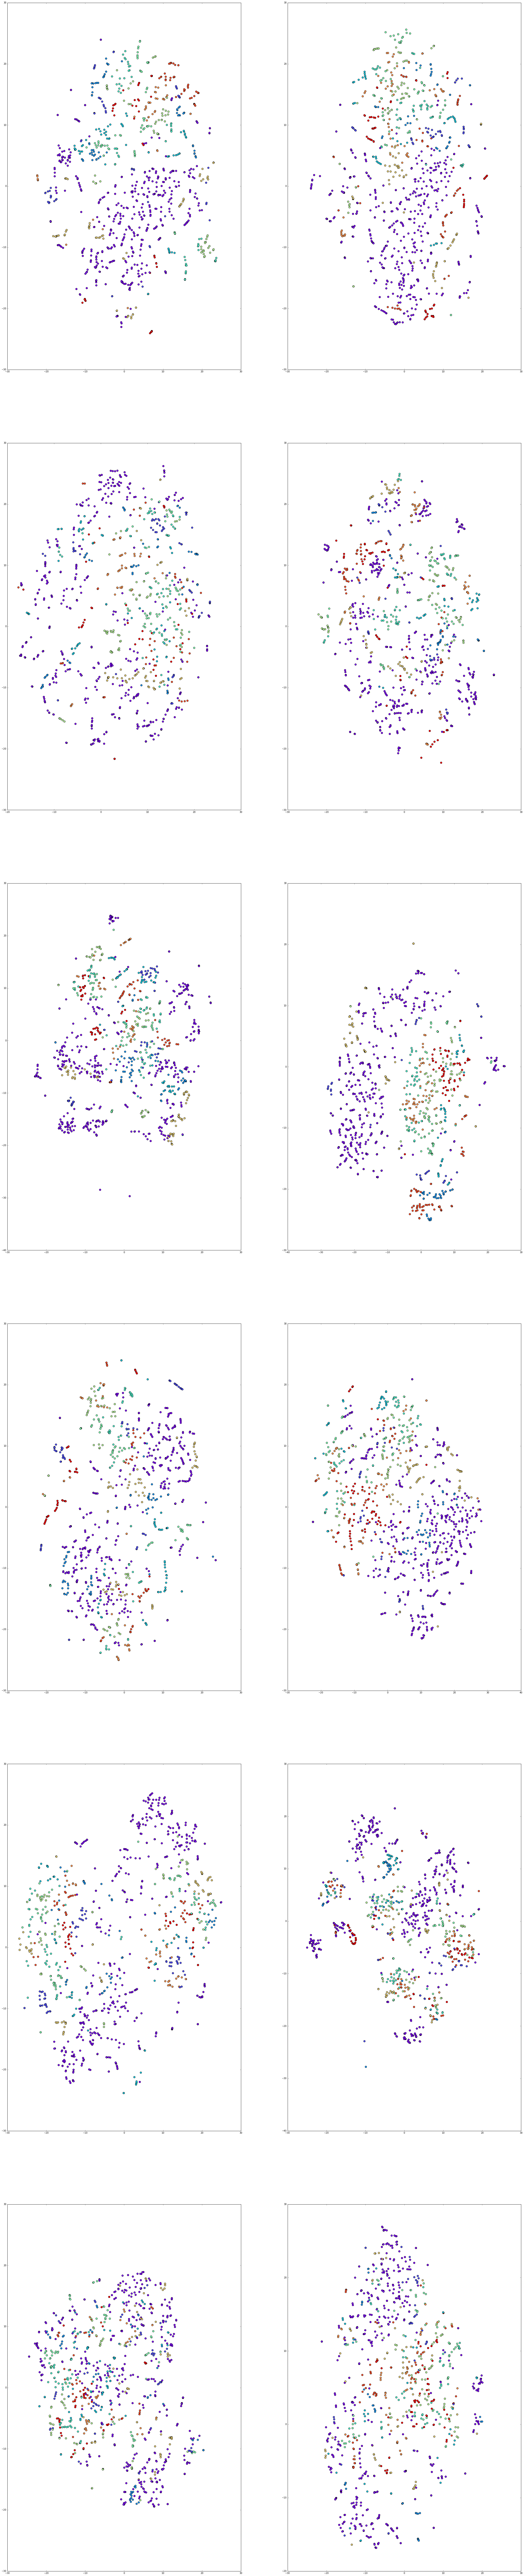

In [26]:
subject_acc = []

fig, ax = plt.subplots(nrows=n_subjects, ncols=2, figsize=(40, 200))
colors = cm.rainbow(np.linspace(0, 1, n_classes))

for subject in range(n_subjects):
    x = xs[subject].swapaxes(1, 2)
    y = ys[subject]
    n = len(x)
    
    x_train = x[:n//3]
    x_val = x[n//3:n*2//3]
    x_test = x[n*2//3:]
    
    y_train = y[:n//3]
    y_val = y[n//3:n*2//3]
    y_test = y[n*2//3:]
    
    x_train_ts = fe[0].fit_transform(x_train, y_train)
    x_val_ts = fe[0].transform(x_val)
    x_test_ts = fe[0].transform(x_test)
    for model in fe[1:]:
        x_train_ts = np.hstack((x_train_ts, model.fit_transform(x_train, y_train)))
        x_val_ts = np.hstack((x_val_ts, model.transform(x_val)))
        x_test_ts = np.hstack((x_test_ts, model.transform(x_test)))

    scaler = StandardScaler()

    x_train_ts = scaler.fit_transform(x_train_ts)
    x_val_ts = scaler.transform(x_val_ts)
    x_test_ts = scaler.transform(x_test_ts)
    
    model = TSNE(n_components=2)
    x_train_pca = model.fit_transform(x_train_ts)
    x_val_pca = model.fit_transform(x_val_ts)
    x_test_pca = model.fit_transform(x_test_ts)
    ax[subject][0].scatter(*x_train_pca[:, 0:2].T, c=colors[y_train], s=60, marker='o')
    #ax[subject][1].scatter(*x_val_pca[:, 0:2].T, c=colors[y_val], s=60, marker='o')
    ax[subject][1].scatter(*x_test_pca[:, 0:2].T, c=colors[y_test], s=60, marker='o')
    
    
    train = np.arange(len(x_train_ts))
    val = np.arange(len(x_val_ts)) + len(train)
    
    x = np.vstack((x_train_ts, x_val_ts))
    y = np.hstack((y_train, y_val))
    
    cv = ((train, val),)
    clf = LogisticRegressionCV(Cs=21, cv=cv, n_jobs=-1)
    clf.fit(x, y)
    y_pred = clf.predict(x_test_ts)

    acc = accuracy_score(y_test, y_pred)
    subject_acc.append(acc)
    print('{} : {}'.format(subject, acc))
    print(confusion_matrix(y_test, y_pred))

print(np.mean(subject_acc))

plt.show()

In [ ]:
#Axes for feature extraction
#Filtering
